Currently the creation of the matched-pairs analysis file is done in python. The goal is a julia script that parses the matched pairs data, and creates tables to use for the test comparisons. 

Output files
- only files with at least one matched pair
- format: <case_number>-shape-matched-pairs.csv
- columns: floe_id, area, convex_area, major_axis_length, minor_axis_length, perimeter, adr_area, adr_convex_area,
           adr_major_axis_length, adr_minor_axis_length, rotation_estimated, minimum_shape_difference, psi_s_correlation, ...

potentially include minimum_sd at a list of rotations, for visualization. e.g., use +/- 45 degrees in steps of 1 degree. Alternatively, 

In [1]:
"""Access the matched pairs from the validation dataset and compute similarity metrics"""

using Pkg
Pkg.activate("../scripts/cal-val")

using IceFloeTracker
using DataFrames, CSV, Images

saveloc = "../data/floe_property_tables/"
ice_floe_database_loc =  "/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/ice_floe_validation_dataset/"
labeled_image_loc = "data/validation_dataset/labeled_floes/"
truecolor_image_loc = "data/modis/truecolor/"
falsecolor_image_loc = "data/modis/falsecolor/"

# Parameters
cloud_mask_settings = (
    prelim_threshold=53.0/255.,
    band_7_threshold=130.0/255.,
    band_2_threshold=169.0/255.,
    ratio_lower=0.0,
    ratio_offset=0.0,
    ratio_upper=0.53
)
min_area = 50
properties = ["label", "area", "bbox", "centroid", "convex_area", "major_axis_length", "minor_axis_length",
              "orientation", "perimeter", "perimeter_crofton"]
column_order = [:label, :row_centroid, :col_centroid,:min_row, :min_col, :max_row, :max_col,
                :area, :convex_area, :major_axis_length, :minor_axis_length, :orientation,
                :perimeter, :perimeter_crofton, :cloud_fraction, :band_7_reflectance, :band_2_reflectance]

LACM = IceFloeTracker.LopezAcostaCloudMask(cloud_mask_settings...)

files = readdir(joinpath(ice_floe_database_loc, labeled_image_loc))
files = [f for f in files if occursin("tiff", f)]; 

for file in files
    labeled_image = channelview(Int64.(load(joinpath(ice_floe_database_loc,  labeled_image_loc, file))))
    case, region, date, satellite, suffix = split(file, "-")    
    falsecolor_image = load(joinpath(ice_floe_database_loc,
                                     falsecolor_image_loc,
                                     join([case, region, "100km", date], "-")*"."*satellite*".falsecolor.250m.tiff"))
    
    df = IceFloeTracker.regionprops_table(labeled_image; properties=properties)
    df = filter(:area => a -> a .> min_area, df)
    
    if nrow(df) > 0
        
        # Get segment means
        cloudmask = IceFloeTracker.create_cloudmask(falsecolor_image, LACM)
        fc_image_data = SegmentedImage(falsecolor_image, labeled_image)
        cm_image_data = SegmentedImage(cloudmask, labeled_image)

        # Add segment means to the dataframe
        df[!,:cloud_fraction] .= [cm_image_data.segment_means[x] for x in df[!, :label]]
        df[!,:band_7_reflectance] .= [red(fc_image_data.segment_means[x]) for x in df[!, :label]]
        df[!,:band_2_reflectance] .= [green(fc_image_data.segment_means[x]) for x in df[!, :label]];
        df[!,:band_1_reflectance] .= [blue(fc_image_data.segment_means[x]) for x in df[!, :label]];
        df = round.(df, digits=2)
        df[!,:area] = convert.(Int64,df[!,:area])
        
        CSV.write(joinpath(saveloc, satellite, replace(file, "labeled_floes.tiff" => "floe_properties.csv")),
          df)
    end
end

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs/scripts/cal-val`
[ Info: Precompiling IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] (cache misses: wrong dep version loaded (4), wrong source (2), incompatible header (12))
[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] (cache misses: wrong dep version loaded (4), incompatible header (10))


In [103]:
nrow(df)

7

In [99]:
saveloc = "../data/floe_property_tables/"


"../data/floe_property_tables/aqua/001-baffin_bay-20220911-aqua-floe_properties.csv"

In [90]:
df[!, column_order]

Row,label,row_centroid,col_centroid,min_row,min_col,max_row,max_col,area,convex_area,major_axis_length,minor_axis_length,orientation,perimeter,perimeter_crofton,cloud_fraction,band_7_reflectance,band_2_reflectance
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float32,Float32
1,1,23,235,18,228,29,242,129.0,134.0,16.1789,10.1817,-1.07094,41.2132,41.7541,0.0542636,0.0914425,0.636844
2,3,196,75,181,62,211,88,581.0,602.0,36.4761,20.3889,0.618615,94.4264,92.2034,1.0,0.578254,0.72933
3,4,221,135,187,96,252,179,4142.0,4298.0,90.2311,59.5305,1.13753,259.338,248.549,0.998551,0.599954,0.795127
4,5,266,240,258,231,273,248,191.0,204.0,19.838,12.4592,-0.977449,52.8701,52.8055,0.958115,0.39959,0.546884
5,6,270,294,264,290,277,297,88.0,91.0,14.0139,8.03437,0.0974669,34.1421,35.0503,0.0454545,0.0807933,0.449822
6,8,278,239,275,232,281,245,86.0,90.0,14.6439,7.48796,-1.54469,34.4853,35.3756,1.0,0.45358,0.655358
7,9,349,241,335,233,362,249,354.0,372.0,28.4487,15.8765,0.203247,72.5269,71.4413,0.731638,0.338618,0.465503


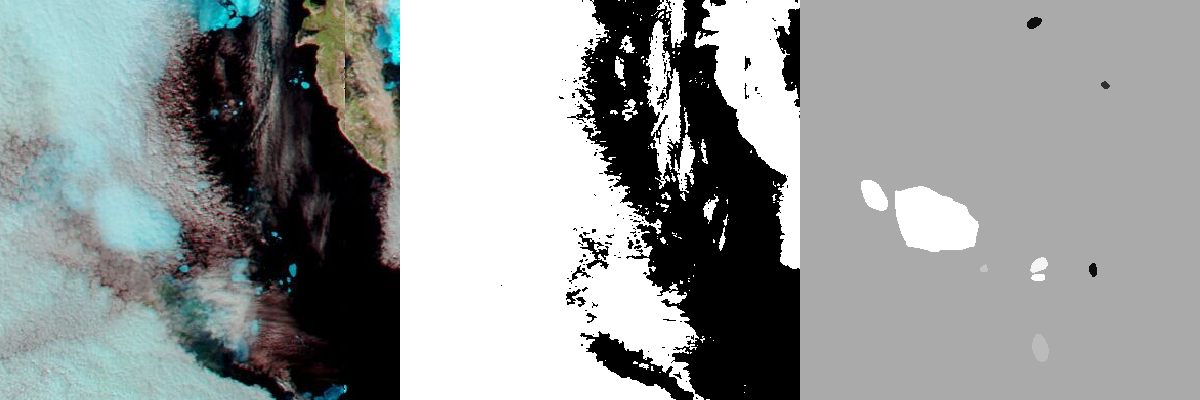

In [67]:
Images.mosaicview(falsecolor_image, Gray.(cloudmask), view_seg(cm_image_data), nrow=1)

In [1]:
"""Access the matched pairs from the validation dataset and compute similarity metrics"""

using Pkg
Pkg.activate("../scripts/cal-val")

using IceFloeTracker
using IceFloeTracker: load, regionprops_table, label_components, imshow, absdiffmeanratio, mismatch, addfloemasks!
using DataFrames, CSV, Interpolations, Images

ice_floe_database_loc =  "/Users/dwatkin2/Documents/research/manuscripts/cal-val_ice_floe_tracker/ice_floe_validation_dataset/"

matched_pairs_tables_loc = joinpath(ice_floe_database_loc, "data/validation_dataset/property_tables/matched")
test_images_loc = joinpath(ice_floe_database_loc, "data/validation_dataset/labeled_floes/")

# convenience functions
greaterthan0(x) = x .> 0 # convert labeled image to boolean
greaterthan05(x) = x .> 0.5 # used for the image resize step
imrotate_bin(x, r) = greaterthan05(collect(imrotate(x, deg2rad(r), method=BSpline(Constant()))))

# expose the non-normalized mismatch from the IFT
function mismatch_temp(fixed::AbstractArray, moving::AbstractArray, test_angles::AbstractArray)
    shape_differences = IceFloeTracker.shape_difference_rotation(
        fixed, moving, test_angles; imrotate_function=IceFloeTracker.imrotate_bin_clockwise_degrees
    )
    best_match = argmin((x) -> x.shape_difference, shape_differences)
    rotation_degrees = best_match.angle
    normalized_area = (sum(fixed) + sum(moving)) / 2
    normalized_mismatch = best_match.shape_difference / normalized_area
    return (mm=normalized_mismatch, rot=rotation_degrees, sd=best_match.shape_difference)
end

  Activating project at `~/Documents/research/manuscripts/cal-val_ice_floe_tracker/calval_tgrs_temp/calval_tgrs/scripts/cal-val`
[ Info: Precompiling IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] (cache misses: wrong dep version loaded (4), wrong source (2), mismatched flags (10))


mismatch_temp (generic function with 1 method)

In [2]:

files = [f for f in readdir(matched_pairs_tables_loc) if occursin(".csv", f)];

In [8]:
file = files[2]
case = split(file, "-")

df_pairs = DataFrame(CSV.File(joinpath(matched_pairs_tables_loc, file)))

# First check for whether there is a match at all
if size(df_pairs)[1] == 1 && !ismissing(df_pairs[1, :aqua_label])
    
    # Load the labeled image and convert to an integer-valued Matrix
    lb_aqua = channelview(Int64.(
                        load(
                            joinpath(test_images_loc, replace(file, "matched-floe_properties.csv" => "aqua-labeled_floes.tiff")))
                            )
                        )
    lb_terra = channelview(Int64.(
                        load(
                            joinpath(test_images_loc, replace(file, "matched-floe_properties.csv" => "terra-labeled_floes.tiff")))
                            )
                        )

    # Retrieve region props and add floe masks
    proplist = ["bbox", "centroid", "label", "area", "convex_area",
        "perimeter", "major_axis_length", "minor_axis_length"]
    
    props_aqua = regionprops_table(lb_aqua);
    props_terra = regionprops_table(lb_terra);
    addfloemasks!(props_aqua, greaterthan0.(lb_aqua));
    addfloemasks!(props_terra, greaterthan0.(lb_terra));

    # Bug in addfloemasks means we have to merge label back in
    props_labels_aqua = regionprops_table(lb_aqua, properties=["area", "label", "bbox"])
    props_labels_terra = regionprops_table(lb_terra, properties=["area", "label", "bbox"])
    global props_aqua = innerjoin(props_aqua, props_labels_aqua, on=[:area, :min_row, :max_row, :min_col, :max_col])
    props_terra = innerjoin(props_terra, props_labels_terra, on=[:area, :min_row, :max_row, :min_col, :max_col])
    
    # Initialize dataframe for the shape comparison
    global df = DataFrame(
               aqua_label=Int64[],
               terra_label=Int64[],               
               aqua_area=Float64[],
               aqua_convex_area=Float64[],
               aqua_major_axis_length=Float64[],
               aqua_minor_axis_length=Float64[],
               aqua_perimeter=Float64[],
               terra_area=Float64[],
               terra_convex_area=Float64[],
               terra_major_axis_length=Float64[],
               terra_minor_axis_length=Float64[],
               terra_perimeter=Float64[],
               adr_area=Float64[],
               adr_convex_area=Float64[],
               adr_major_axis_length=Float64[],
               adr_minor_axis_length=Float64[],
               rotation_estimated=Float64[],
               minimum_shape_difference=Float64[],
               psi_s_correlation=Float64[],
               )

    for matches in eachrow(df_pairs)
        global row_aqua = props_aqua[props_aqua.label .== matches.aqua_label, :]
        row_terra = props_terra[props_terra.label .== matches.terra_label, :]

        normalized_mismatch, rotation_degrees, shape_difference = mismatch_temp(row_aqua[1, :mask], row_terra[1, :mask], -45:1:45)
        try
            _psi = IceFloeTracker.buildψs.([row_aqua[1, :mask], row_terra[1, :mask]])
            global psi_s_correlation = round(IceFloeTracker.corr(_psi...), digits=3)
        
        catch e
            @warn "Build Psi-S failed: $e"
            global psi_s_correlation = NaN
        end
        
        push!(df, (matches.aqua_label,
                   matches.terra_label,
                   row_aqua[1, :area],
                   row_aqua[1, :convex_area],
                   row_aqua[1, :major_axis_length],
                   row_aqua[1, :minor_axis_length],
                   row_aqua[1, :perimeter],
                   row_terra[1, :area],
                   row_terra[1, :convex_area],
                   row_terra[1, :major_axis_length],
                   row_terra[1, :minor_axis_length],
                   row_terra[1, :perimeter],                
                   0.5*absdiffmeanratio(row_aqua[1, :area], row_terra[1, :area]),
                   0.5*absdiffmeanratio(row_aqua[1, :convex_area], row_terra[1, :convex_area]),
                   0.5*absdiffmeanratio(row_aqua[1, :major_axis_length], row_terra[1, :major_axis_length]),
                   0.5*absdiffmeanratio(row_aqua[1, :minor_axis_length], row_terra[1, :minor_axis_length]),
                   rotation_degrees,
                   shape_difference,
                   psi_s_correlation
                   )) 
    end
    # TBD: Initialize dataframe to store the rotation vs SD vectors 
end
nothing

In [120]:
df

Row,aqua_label,terra_label,aqua_area,aqua_convex_area,aqua_major_axis_length,aqua_minor_axis_length,aqua_perimeter,terra_area,terra_convex_area,terra_major_axis_length,terra_minor_axis_length,terra_perimeter,adr_area,adr_convex_area,adr_major_axis_length,adr_minor_axis_length,rotation_estimated,minimum_shape_difference,psi_s_correlation
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,83.0,88.0,12.11,8.74504,32.1421,66.0,73.0,9.66538,9.04707,29.3137,0.114094,0.0931677,0.112263,0.0169754,45.0,23.0,0.984


In [10]:
addfloemasks!(props_aqua[:, [x for x in names(props_aqua) if x != "label"]], lb_aqua .> 0)

In [13]:
props_labels_aqua = regionprops_table(lb_aqua, properties=["area", "label"])
props_labels_terra = regionprops_table(lb_terra, properties=["area", "label", "perimeter", "perimeter_crofton" ])

Row,area,label,perimeter,perimeter_crofton
,Float64,Int64,Float64,Float64
1,66.0,1,29.3137,30.4727
2,47.0,2,23.8995,25.3397
3,32.0,3,19.6569,21.3174


In [111]:
innerjoin(props_aqua, props_labels_aqua, on=[:area, :min_row, :max_row, :min_col, :max_col])

LoadError: UndefVarError: `innerjoin!` not defined in `Main`
Suggestion: check for spelling errors or missing imports.